In [1]:
import atmPy.radiation.retrievals.langley_calibration as atmlc

In [2]:
import helpers

# AOD

In [3]:
prefix = '/Users/htelg'
overwrite = True
version = '0.5'
version_langleys = '0.4'
serial_no = 648
p2fld_out = pl.Path(f'{prefix}/nfs/grad/campaign/frc/2025/AOD/US_NOAA_MFR#8/netcdf/v{version}/')
p2fld_mfrsr = pl.Path(f'{prefix}/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/{serial_no}.cal/v0.1/')
p2fld_met = pl.Path(f'{prefix}/nfs/grad/campaign/frc/2025/MetaData.netcdf/')
"""changelog
------------
== v0.2== 
- subtruct aod from 940 by extrapolating with angstrom exponent
== v0.3 ==
- use aeronet precipitable water instead
== v0.4 ==
- added uncertainties
== v0.5 ==
- langleys slightly different due to improved airmass
- removed 940 channel
"""

'changelog\n------------\n== v0.2== \n- subtruct aod from 940 by extrapolating with angstrom exponent\n== v0.3 ==\n- use aeronet precipitable water instead\n== v0.4 ==\n- added uncertainties\n== v0.5 ==\n- langleys slightly different due to improved airmass\n- removed 940 channel\n'

## langley calibration

### load calibration

In [4]:
p2f = f'data/V0_simple_{serial_no}_v{version_langleys}.nc'
V0 = xr.open_dataset(p2f)
V0.attrs['path2file'] = p2f

In [5]:
V0

<xarray.Dataset> Size: 344B
Dimensions:                              (wavelength: 6)
Coordinates:
  * wavelength                           (wavelength) int64 48B 415 500 ... 1625
    quantile                             float64 8B ...
Data variables:
    V0                                   (wavelength) float64 48B ...
    V0_std                               (wavelength) float64 48B ...
    no_langleys                          (wavelength) int64 48B ...
    one_sided_upper_bound_factor_95conf  (wavelength) float64 48B ...
    OD_uncertainty                       (wavelength) float64 48B ...
    V0_stderr                            (wavelength) float64 48B ...
Attributes:
    path2file:  data/V0_simple_648_v0.4.nc

In [6]:
V0.OD_uncertainty.compute()

<xarray.DataArray 'OD_uncertainty' (wavelength: 6)> Size: 48B
array([0.02675382, 0.02409394, 0.02029891, 0.01888447, 0.09520396,
       0.01093953])
Coordinates:
  * wavelength  (wavelength) int64 48B 415 500 670 870 940 1625
    quantile    float64 8B 0.9
Attributes:
    description:  (V0_std / V0 * osub) + 0.005. osub: one-sided upper bound f...

# look up table

In [7]:
fnlut = '/Users/htelg/projects/mfrsr2pwv/data/pwd_od_lut_648.nc'
ds_lut = xr.open_dataset(fnlut)
ds_lut.attrs.update({'path2file': fnlut})

# the product

In [8]:
import atmPy.radiation.retrievals.spectral_irradiance as atmspec
import atmPy.aerosols.physics.column_optical_properties as atmcop

In [9]:
reload(atmspec)

<module 'atmPy.radiation.retrievals.spectral_irradiance' from '/Users/htelg/prog/atm-py/atmPy/radiation/retrievals/spectral_irradiance.py'>

In [10]:
def make_product(fn,
                 fnmet,
                 fnlut,
                 langley_calibration,
                 serial_no,
                 version,
                verbose = False):
    out = {}
    ds = xr.open_dataset(fn)
    ds.attrs['site_longitude'] = 9.8458 
    ds.attrs['site_latitude'] = 46.8143 
    ds.attrs['site_elevation'] = 1590
    out['ds_original'] = ds.copy()
    dsmet = xr.open_dataset(fnmet)
    out['dsmet'] = dsmet
    gdd = atmspec.CombinedGlobalDiffuseDirect(ds.copy(), verbose = verbose)
    gdd.dataset['channel_wavelength'] = gdd.dataset.channel_wavelength.astype(float) #error in processing upstream, fix it in future versions!
    gdd = gdd.apply_calibration_langley(langley_calibration)
    
    ### Moving to direct
    dni = gdd.direct_normal_irradiation
    out['dni_inst'] =  dni
    dni.verbose = True
    
    # met data
    dni.met_data = dsmet
    
    #lookuptable for precipitagble water
    # dni.precipitable_water = fnlut
    
    # ozone
    # dni.ozone_data = 300
    ozone = dsmet.ozone.where(dsmet.ozone != -99.999)
    ozone = ozone.interpolate_na('time', method = 'nearest', fill_value = 'extrapolate')
    dni.ozone_data = ozone

    # precipitable water
    # dni.precipitable_water_varname = 'precipitable_water_aeronet''
    pwv = dsmet.precipitable_water_aeronet/10
    dni.precipitable_water = pwv.where(pwv >= 0)
    # return dni
    # retrieve it all
    dni.dataset.attrs['serial_no'] = serial_no #when looking for filters it will need the serial number
    # return out
    dni.absorption_correction_coeff_1625 =  '1625nm_absorption_correction_coefficience.nc'
    dni.aod #this will trigger the retrieval and populate the raw_data
    
    # create cloud flag
    aod = atmcop.AOD_AOT(dni.dataset)
    cm = aod.cloudmask.cloudmask_michalsky
    cm = cm.where(~ np.isnan(cm), 2).astype('int8')
    cm.attrs.update({
        "long_name": "cloud detection flag",
        "standard_name": "status_flag",
        "units": "1",
        "flag_values": '0, 1, 2',
        "flag_meanings": "no_cloud_detected cloud_detected algorithm_not_run",
        "description": (
            "0 = no cloud detected; 1 = cloud detected; "
            "2 = algorithm could not be evaluated"
        ),
    })
    out['cloud_flag'] = cm.copy()
    dni.dataset['cloud_flag'] = cm

    # aod uncertainties
    am = dni.sun_position.airmass
    aoduc = langley_calibration.OD_uncertainty/am
    aoduc = aoduc.rename({'wavelength': 'channel'})
    
    # format the file
    drop = ['alltime','toa_spectral_irradiance','ozone_absorption_spectrum', 'ozon_absoption_by_channel', 'wavelength', 'direct_horizontal']
    prod = dni.dataset.drop_vars(drop)

    # remove the 940 channel
    prod[aod] = prod.aod.where(prod.channel != 940) 
    # prod = prod.sel(channel=[i for i in ds.channel.values if i != 940])
    # prod = prod.where(prod.channel != 940) 
    
    od1625 = dni.od_co2_ch4_h2o.sel(channel = 1625, drop = True)
    prod['od_1625nm_co2'] = od1625.co2
    prod['od_1625nm_ch4'] = od1625.ch4
    prod['od_1625nm_h2o'] = od1625.h2o_5cm

    prod['aod_uncertainty'] = aoduc
    prod.aod_uncertainty.attrs['description'] = 'Absolute AOD uncertainty based on Langley calibration. airmass^-1  ((V0_std / V0 * osub) + 0.005). osub: one-sided upper bound factor with a 95% confidence, mostly relevant for small number of langleys.'
    
    prod['airmass'] = am
    
    prod = prod[["aod",
                 "aod_uncertainty",
                 "cloud_flag",
                # "precipitable_water",
                "transmission",
                "global_horizontal",
                "diffuse_horizontal",
                "direct_normal",
                "od_rayleigh",
                "od_ozone",
                "od_1625nm_co2",
                "od_1625nm_ch4",
                "od_1625nm_h2o",
                "channel_wavelength",
                "cosine_calibraion_direct",
                "solar_zenith_angle",
                "solar_azimuth_angle",
                 "airmass",
                "pressure",
                "temperature",
                "ozone_data",]]


    
    # add some attributes
    attrs = dict(description = 'Spectral AOD, downwelling fluxes, and precipitable water from NOAA/GRAD MFRSR instruments during 2025 FRC in Davos',
                site_longitude = f'{360 + prod.attrs['site_longitude']:0.6f}',
                site_latitude = f'{prod.attrs['site_latitude']:0.6f}',
                site_elevation = f'{prod.attrs['site_elevation']:0.0f}',
                 serial_no = prod.attrs['serial_no'],
                 instrument_type = prod.attrs['instrument_type'],
                 input_files = ', '.join([fn.as_posix(), fnmet.as_posix(), fnlut.attrs['path2file'], langley_calibration.path2file]),
                 processing_timestamp = f'{pd.Timestamp.now()}',
                 product_version = version
                )          
    
    prod.attrs = attrs


    # dni.toa_spectral_irradiance # this is already adjusted to sun earth distan

    out['product'] = prod 
    return out

In [11]:
# Test
out = make_product(fn = pl.Path(f'{prefix}/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/648.cal/v0.1/frc_648_v0.1_20250929.nc'),
                 fnmet = pl.Path(f'{prefix}/nfs/grad/campaign/frc/2025/MetaData.netcdf/frc-vi_metadata_20250929_preliminary.nc'),
                 fnlut =  ds_lut,
                 langley_calibration = V0,
                 serial_no = 648,
                 version = version)
# dni = out

Renaming time coordinate to datetime for ozone data.


/Users/htelg/miniconda3/envs/py12/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/Users/htelg/miniconda3/envs/py12/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


Calculating ozone optical depth for each channel.


/Users/htelg/prog/atm-py/atmPy/aerosols/physics/column_optical_properties.py:1108: UserWarning: Michalsky cloudmask may not work well for very low AOD values (<0.02, this values will need to be tested better)
  warnings.warn('Michalsky cloudmask may not work well for very low AOD values (<0.02, this values will need to be tested better)')


In [12]:
out.keys()
dni = out['dni_inst']

In [13]:
ds = out['product']

(-0.01, 0.05)

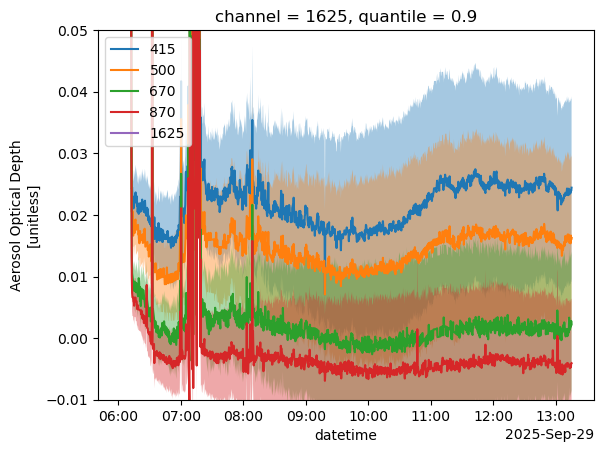

In [14]:
wls = [
    415,
    500,
    670,
    870,
    1625
]
alpha = 0.4
f,a = plt.subplots()
for wl in wls:
    aod = ds.aod.sel(channel = wl)
    aod.plot(ax = a, label = wl)
    col = a.get_lines()[-1].get_color()
    if 1:
        uc = ds.aod_uncertainty.sel(channel = wl)
        a.fill_between(aod.datetime, aod - uc, aod + uc, alpha = alpha, zorder = 0, color = col, linewidth = 0)
    # break
        
a.legend()
a.set_ylim(-0.01, 0.05)

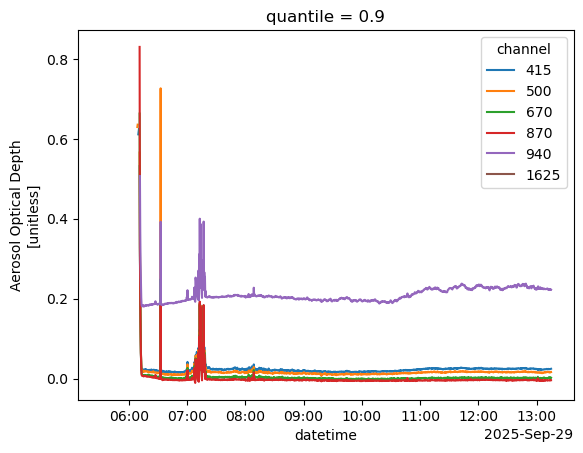

In [15]:
ds.aod.plot.line(x = 'datetime',)


# Workplan

In [16]:
'/Users/htelg/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/648.cal/v0.1/'

'/Users/htelg/nfs/grad/Inst/MFR/Campaign/frc/2025/mfrsr/648.cal/v0.1/'

In [17]:
dfmfrsr = pd.DataFrame(p2fld_mfrsr.glob('*.nc'), columns=['p2f_mfrsr_in'])
dfmfrsr.index = dfmfrsr.apply(lambda row: pd.to_datetime(row.p2f_mfrsr_in.name.split('_')[-1].replace('.nc','')), axis =1)

dfmet = pd.DataFrame(p2fld_met.glob('*.nc'), columns=['p2f_met'])
dfmet.index = dfmet.apply(lambda row: pd.to_datetime(row.p2f_met.name.split('_')[-2]), axis = 1)

mp = pd.concat([dfmfrsr,dfmet], axis = 1)
mp['p2f_out'] = mp.apply(lambda row: p2fld_out.joinpath(f'aod_frc_{serial_no}_v{version}_{row.name.strftime('%Y%m%d')}.nc'), axis = 1)

In [18]:
wp = mp.dropna()
if not overwrite:
    wp = wp[~wp.apply(lambda row: row.p2f_out.exists(), axis = 1)]

In [19]:
wp

,p2f_mfrsr_in,p2f_met,p2f_out
2025-09-25,/Users/htelg/nfs/grad/Inst/MFR/Campaign/frc/20...,/Users/htelg/nfs/grad/campaign/frc/2025/MetaDa...,/Users/htelg/nfs/grad/campaign/frc/2025/AOD/US...
2025-09-26,/Users/htelg/nfs/grad/Inst/MFR/Campaign/frc/20...,/Users/htelg/nfs/grad/campaign/frc/2025/MetaDa...,/Users/htelg/nfs/grad/campaign/frc/2025/AOD/US...
2025-09-27,/Users/htelg/nfs/grad/Inst/MFR/Campaign/frc/20...,/Users/htelg/nfs/grad/campaign/frc/2025/MetaDa...,/Users/htelg/nfs/grad/campaign/frc/2025/AOD/US...
2025-09-28,/Users/htelg/nfs/grad/Inst/MFR/Campaign/frc/20...,/Users/htelg/nfs/grad/campaign/frc/2025/MetaDa...,/Users/htelg/nfs/grad/campaign/frc/2025/AOD/US...
2025-09-29,/Users/htelg/nfs/grad/Inst/MFR/Campaign/frc/20...,/Users/htelg/nfs/grad/campaign/frc/2025/MetaDa...,/Users/htelg/nfs/grad/campaign/frc/2025/AOD/US...
2025-10-01,/Users/htelg/nfs/grad/Inst/MFR/Campaign/frc/20...,/Users/htelg/nfs/grad/campaign/frc/2025/MetaDa...,/Users/htelg/nfs/grad/campaign/frc/2025/AOD/US...
2025-10-02,/Users/htelg/nfs/grad/Inst/MFR/Campaign/frc/20...,/Users/htelg/nfs/grad/campaign/frc/2025/MetaDa...,/Users/htelg/nfs/grad/campaign/frc/2025/AOD/US...
2025-10-03,/Users/htelg/nfs/grad/Inst/MFR/Campaign/frc/20...,/Users/htelg/nfs/grad/campaign/frc/2025/MetaDa...,/Users/htelg/nfs/grad/campaign/frc/2025/AOD/US...
2025-10-04,/Users/htelg/nfs/grad/Inst/MFR/Campaign/frc/20...,/Users/htelg/nfs/grad/campaign/frc/2025/MetaDa...,/Users/htelg/nfs/grad/campaign/frc/2025/AOD/US...
2025-10-06,/Users/htelg/nfs/grad/Inst/MFR/Campaign/frc/20...,/Users/htelg/nfs/grad/campaign/frc/2025/MetaDa...,/Users/htelg/nfs/grad/campaign/frc/2025/AOD/US...


# work it

In [20]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
overwrite = True
for idx, row in wp.iterrows():
    if row.p2f_out.exists():
        if not overwrite:
            continue
        else:
            row.p2f_out.unlink()
        

    try:
        out = make_product(fn = row.p2f_mfrsr_in,
                 fnmet = row.p2f_met,
                 fnlut =  ds_lut,
                 langley_calibration = V0,
                 serial_no = serial_no,
                 version = version)        
        prod = out['product']
        row.p2f_out.parent.mkdir(parents=True, exist_ok=True)
        prod.to_netcdf(row.p2f_out)
    except:
        raise
        print('something went wrong')
        continue

Renaming time coordinate to datetime for ozone data.
Calculating ozone optical depth for each channel.
Renaming time coordinate to datetime for ozone data.
Calculating ozone optical depth for each channel.
Renaming time coordinate to datetime for ozone data.
Calculating ozone optical depth for each channel.
Renaming time coordinate to datetime for ozone data.
Calculating ozone optical depth for each channel.
Renaming time coordinate to datetime for ozone data.
Calculating ozone optical depth for each channel.
Renaming time coordinate to datetime for ozone data.
Calculating ozone optical depth for each channel.
Renaming time coordinate to datetime for ozone data.
Calculating ozone optical depth for each channel.
Renaming time coordinate to datetime for ozone data.
Calculating ozone optical depth for each channel.
Renaming time coordinate to datetime for ozone data.
Calculating ozone optical depth for each channel.
Renaming time coordinate to datetime for ozone data.
Calculating ozone op

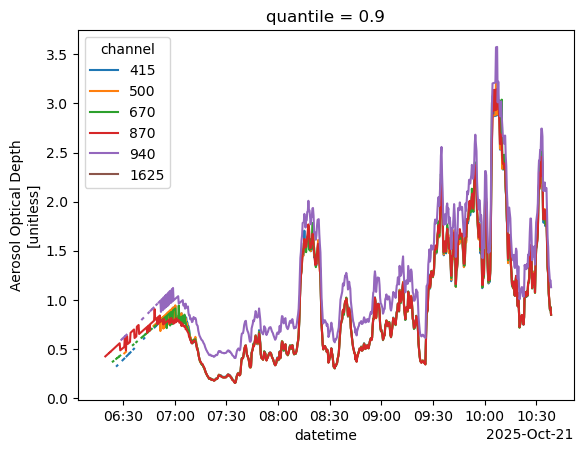

In [22]:
prod.aod.plot.line(x = 'datetime')

In [23]:
p2fl = list(p2fld_out.glob('*'))
p2fl.sort()

In [24]:
ds = xr.open_mfdataset(p2fl)

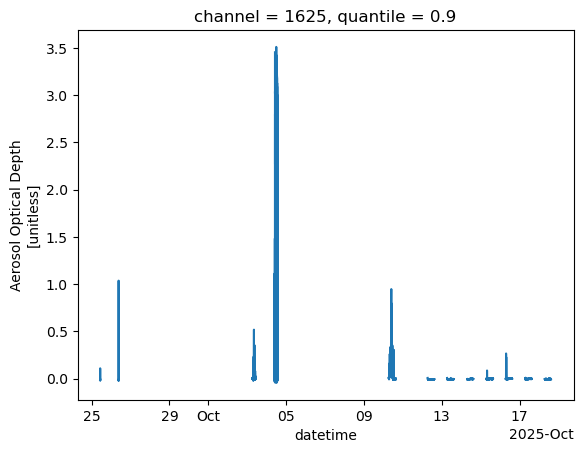

In [25]:
ds.aod.sel(channel = 1625).plot()

In [26]:
p2fl = list(p2fld_out.glob('*'))
p2fl.sort()

In [27]:
ds = xr.open_mfdataset(p2fl)

In [28]:
ds.precipitable_water.plot()

AttributeError: 'Dataset' object has no attribute 'precipitable_water'